# Training a RNN to learn sequences from "Don Quijote de la Mancha"

This notobook is based on the lab1 session from the MIT at <a href="http://introtodeeplearning.com/">http://introtodeeplearning.com/</a>

## Requirements:
- Tensorflow: here I'm using tensorflow 2.1.0
- Numpy
- Tqdm
- Matplotlib

## Import libraries

In [1]:
%matplotlib inline
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import pylab as pl
from IPython import display

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense
print(f"Tensorflow version: {tf.__version__}")

import mitdeeplearning as mdl

Tensorflow version: 2.1.0


## Load data

In [2]:
# Read file
with open(os.path.join(r'txt_source', r'el_quijote.txt')) as f:
    txt = f.read()

# Create idx - character converters
idx2char = np.array(sorted(set(txt)))
char2idx = {c:i for i, c in enumerate(idx2char)}

print(f"Found {len(idx2char)} characters")

# Vectorize txt
vect_txt = np.array([char2idx[c] for c in txt])

Found 89 characters


## Batch creation

In [3]:
def get_batch(vect_txt, seq_length, batch_size):
    while True:
        # Get indexes
        idx = np.random.choice(vect_txt.shape[0] - seq_length - 1, batch_size)

        # Create batches
        input_batch = [vect_txt[i:i+seq_length] for i in idx]
        output_batch = [vect_txt[i+1:i+seq_length+1] for i in idx]

        # Reshape
        x_batch = np.reshape(input_batch, [batch_size, seq_length])
        y_batch = np.reshape(output_batch, [batch_size, seq_length])
        yield (x_batch, y_batch)

## Define model

In [4]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        # Layer 1: Embedding layer to transform indices into dense vectors 
        #   of a fixed embedding size
        tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

        # Layer 2: LSTM with `rnn_units` number of units. 
        tf.keras.layers.LSTM(
            rnn_units, 
            return_sequences=True, 
            recurrent_initializer='glorot_uniform',
            recurrent_activation='sigmoid',
            stateful=True,
        ),

        # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
        #   into the vocabulary size. 
        tf.keras.layers.Dense(vocab_size)
    ])

    return model

model = build_model(len(idx2char), embedding_dim=256, rnn_units=1024, batch_size=32)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           22784     
_________________________________________________________________
lstm (LSTM)                  (32, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (32, None, 89)            91225     
Total params: 5,360,985
Trainable params: 5,360,985
Non-trainable params: 0
_________________________________________________________________


In [5]:
x, y = get_batch(vect_txt, seq_length=100, batch_size=32).__next__()
pred = model(x)
print(x.shape, pred.numpy().shape)

# To get the output we don't use argmax (wich apparently may cause the model to be enter a loop),
# instad we sample from the distribution.
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

print("Input: \n", repr("".join(idx2char[x[0]])))
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

(32, 100) (32, 100, 89)
Input: 
 'ro.\nLuego si es de esencia que todo caballero andante haya de ser enamorado, dijo el caminante, bien'
Next Char Predictions: 
 'FhWteFVzsf̈Y<Cspt;N6dXm q<]“im4oyR2M̀“NK’G2LH(«o2g2‘c‘̀lJ7<P‘d¡\nn̈s‘oR̃d?R.’](Zd4lQNg“[8Nb8¡--<]lX<.'


## Hyperparameter

In [6]:
# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(idx2char)
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

## Training

- Train step

In [7]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y): 
    with tf.GradientTape() as tape:
        y_pred = model(x)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y, y_pred, from_logits=True)
        
        grads = tape.gradient(loss, model.trainable_variables)

        # Apply the gradients with the optimizer
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss

- Train loop

In [9]:
# model.compile(optimizer=optimizer, loss=tf.keras.losses.sparse_categorical_crossentropy)

# model.fit(get_batch(vect_txt, seq_length, batch_size), epochs=num_training_iterations, callbacks=[])

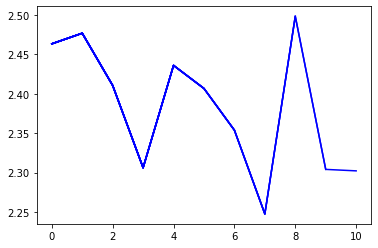

  1%|          | 11/2000 [00:26<1:18:29,  2.37s/it]


KeyboardInterrupt: 

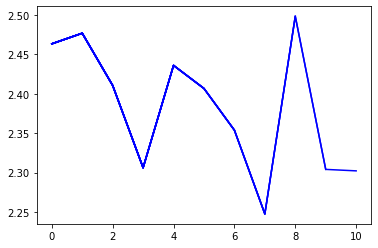

In [13]:
history = []
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):
    # Grab a batch and propagate it through the network
    x_batch, y_batch = get_batch(vect_txt, seq_length, batch_size).__next__()
    loss = train_step(x_batch, y_batch)

    # Update the progress bar
    history.append(loss.numpy().mean())
    pl.plot(history, 'b-')
    display.clear_output(wait=True)
    display.display(pl.gcf())

    # Update the model with the changed weights!
    if iter % 100 == 0:     
        model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

## Restore model

In [14]:
model_new = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

# Restore the model weights for the last checkpoint after training
model_new.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model_new.build(tf.TensorShape([1, None]))

model_new.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            22784     
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_2 (Dense)              (1, None, 89)             91225     
Total params: 5,360,985
Trainable params: 5,360,985
Non-trainable params: 0
_________________________________________________________________


## Generate text from model

In [15]:
def generate_text(model_new, start_string="la ", generation_length=100):
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Here batch size == 1
    model_new.reset_states()
    tqdm._instances.clear()

    for i in tqdm(range(generation_length)):
        predictions = model_new(input_eval)

        # Remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        #predicted_id = np.argmax(predictions.numpy()[-1])
        
        # Pass the prediction along with the previous hidden state
        #   as the next inputs to the model
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

generated_text = generate_text(model_new, start_string="Javi es el puto amo porque ", generation_length=500)

100%|██████████| 500/500 [00:08<00:00, 55.69it/s]


In [16]:
print(generated_text[:500])

Javi es el puto amo porque ro, ton ́n laso so Dos des ememmdtestl edoot;nipá,r, Pen, ye diso mo miesasi tasoon utetena Sesda y la ;Cpioran eso ysran denridien esa oy e lonr dda iens cesdili, mumasas lr:, cnse ciA medebenhrala ce ena eRanema co do qosva ń me enqml dedo teo, nnbd mie sdan ond, stidisrisa ygalucecao tálo mon eneomh deorralodalO lmran,s qumdce muioSma, sola, Conmeruo ltorosra, pite roo de ontt . dest.l Drrtr ccemon ce que denta os tder mezonlénten erre uela moesdis e :lie cu.sa 
